# Script for the creation of the built-in MM (macromollecule) basis

Inspired by "Towards a Fitting Model of Macromolecular Spectra: Amino Acids" by Tamás Borbáth, Saipavitra Murali Manohar and Anke Henning. Proc. Intl. Soc. Mag. Reson. Med. 27 (2019) #1068.  
https://cds.ismrm.org/protected/19MPresentations/abstracts/1068.html  
https://cds.ismrm.org/protected/19MPresentations/scivids/1068/

## Intro
- The metabolite resonance's basis spectra in 1H MRS can be created from known chemical shifts and j-coupling constants using density matrix simulation.
- The basis set(s) for the macromollecule signals are often either  modeled as unlinked single peaks combined with a flexible baseline or measured using inversion nulled spectra. The former in unsatisfactory for fit quality and the latter, though robust, requires additional scans, expertise and potentially sequence modifications.
- The macromollecule resonances arise from amino acids present in peptides and proteins in the ROI. See Behar et al MRM 1993;30:38-44 and Behar et al MRM 1994;32:294-302.
- The protein NMR comunity publishes assigned chemical shifts from peptides and protines in databases such as the Biological Magnetic Resonance Data Bank (BMRB). Ulrich EL, Akutsu H, Doreleijers JF, Harano Y, Ioannidis YE, Lin J, Livny M, Mading S, Maziuk D, Miller Z. BioMagResBank. Nucleic acids research 2007;36:D402-D408
- Different sequences and 3D structures of amino acid chains lead to somehwat broad distributions of chemical shifts.
- Borbáth et al showed that histograms of the amino acid residue chemical shifts in the BMRB could be used as a basis set for the macromollecule signal from human brain spectra at 9.4 T.
- The authors of this package found that this method did not produce usable basis spectra for fields of 7T and below as the histograms created from the BMRB were too broad for use at these lower field strengths.
- To provide fitting functionallity for spectra including MM resonances without the need for inversion nulled spectra the authors have modifed the methods of Borbáth et al to provide greater flexibility of peak width.  

## Method
This script generates the built-in macromollecule basis spectra included in FSL-MRS.

1) For a subset of the amino acids residues the BMRB is polled through its RESTful API for all proton chemical shift assignments. The ambiguity level is set to '1' (no ambiguity of assignment).  
2) These distributions are filtered to exclude any assigmnets over a certain number of standard deviations from the mean of that particular resonance. This is to exclude measurements made in unusual conditions.  
3) The maximum and standard deviation of the distribution of shifts for each resonance of each residue is measured and stored as a peak shift and width.  
4) Additional shifts are made for each residue, calibrated from pre-measured MM signals.  
5) For fitting the basis FIDs for each residue is created as a sum of exponentially damped sinusoids (Lorentzians) at the position of the stored shifts and with fwhm relative to the widths.  
6) For fitting all MM basis sets are assigned the same global shift and broadening. This avoids giving the model too much flexibility.  


**The authors consider this method highly experimental. It is included as a tool for those situations where a full MM description has not yet been measured, or cannot be measured. We recommend the inversion-nulled measurement of MM as the current 'gold-standard'.**

In [179]:
%load_ext autoreload
%autoreload 2

import numpy as np
from fsl_mrs.utils import mrs_io,plotting,fitting
from fsl_mrs.core import MRS
from fsl_mrs.mmbasis import mmbasis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fetch the shifts and widths from the BMRB database

In [180]:
residues = ['ALA','ARG','ASN','ASP','GLU','GLN','LEU','LYS','MET','PHE','PRO','THR','TYR','ILE','VAL']

positions,widths = mmbasis.createMMBasis(residues,sd=2,ambiguity='1')

http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=ALA&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=ARG&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=ASN&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=ASP&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=GLU&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=GLN&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=LEU&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=LYS&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical_shifts?comp_id=MET&atom_type=H&database=macromolecules
OK!
http://webapi.bmrb.wisc.edu/v2/search/chemical

### Load some data to fit to check and tune the basis description
This data is inversion-nulled MM resonances from:  
- A 7T STEAM sequence (TE =11)
- A 7T sLASER sequence (TE = 36)
- A 3T sLASER sequence (TE = 28)
- The MM basis from the ISMRM study group fitting challenge (3T PRESS) https://www.ismrm.org/workshops/Spectroscopy16/mrs_fitting_challenge/

In [232]:
basisSeq = ['3T sLaser','7T STEAM','7T sLASER','3T PRESS']
basisPaths = ['oldBasisSets/sLASER_3T_28ms.BASIS','oldBasisSets/STEAM_7T_11ms.BASIS','oldBasisSets/sLASER_7T_36ms.BASIS','oldBasisSets/PRESS_3T_30ms.BASIS']
mmName = ['Mac','mm','mm','Mac']
mmData = []
mmCf = []
mmBW = []
mmpoints = []
for paths,mmid in zip(basisPaths,mmName):
    data, metabo, header = mrs_io.readLCModelBasis(paths)
    mmIndex = metabo.index(mmid)
    mmData.append(data[:,mmIndex])
    mmCf.append(header['centralFrequency'])
    mmBW.append(header['bandwidth'])
    mmpoints.append(data.shape[0])

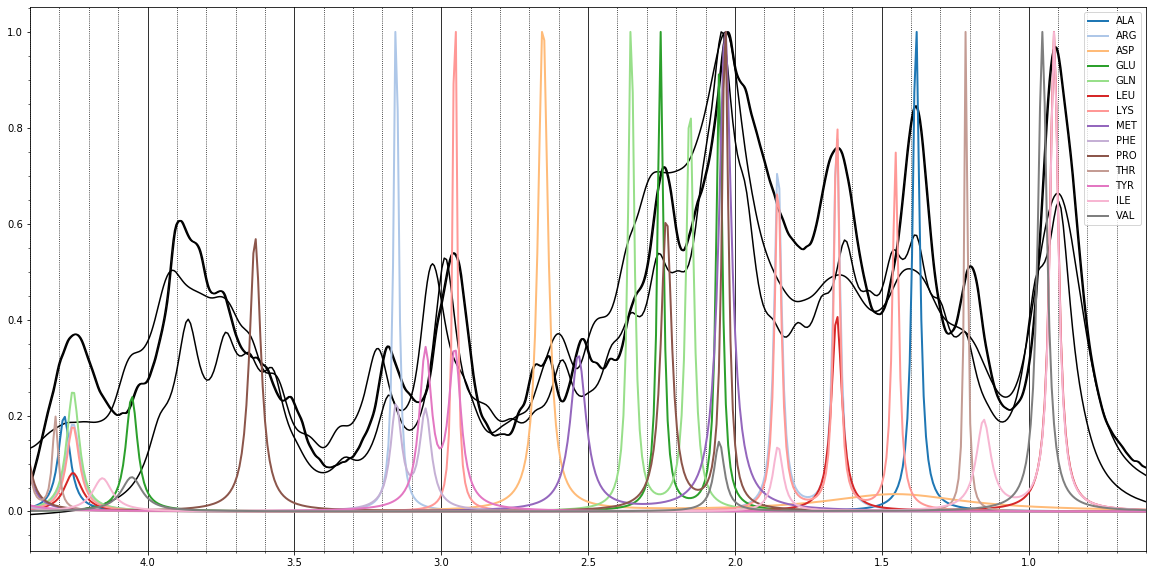

In [256]:
import matplotlib
import matplotlib.pyplot as plt
import copy

# Touch up the LEU and ILE HD resonances which seem to be ~0.1 ppm low.
modPos = copy.deepcopy(positions)
leuIndex = residues.index('LEU')
for iDx,p in enumerate(modPos[leuIndex]):
    if modPos[leuIndex][iDx] < 1.0:
        modPos[leuIndex][iDx] +=0.06
ileIndex = residues.index('ILE')
for iDx,p in enumerate(modPos[ileIndex]):
    if modPos[ileIndex][iDx] < 1.0:
        modPos[ileIndex][iDx] +=0.06

# Touch up the THR widths.
modw = copy.deepcopy(widths)
thrIndex = residues.index('THR')
modw[thrIndex] = [i*0.5 for i in modw[thrIndex]]

# Slight shift in position for ALA, THR, MET and PRO
shiftDict = {'ALA':0.03,'THR':0.06,'MET':-0.02,'PRO':-0.02}
for iDx,(p,n) in enumerate(zip(modPos,residues)):
    if n in shiftDict:
        modPos[iDx] = [i+shiftDict[n] for i in modPos[iDx]]

# Plot the data
plt.figure(figsize=(20,10))
for FID,cf,bw,points,seq in zip(mmData,mmCf,mmBW,mmpoints,basisSeq):
    ppmaxis = np.linspace(-bw/2,bw/2,points)/(cf/1E6)
    toPlot = np.real(plotting.FID2Spec(FID))
    toPlot /= np.max(toPlot)
    plt.plot(ppmaxis+4.65,toPlot,'k-')

# Plot residues
taxis = np.arange(0,points*(1/bw),1/bw)
basisFIDs = []
lw = 20
for p,w,r in zip(modPos,modw,residues):
    curFID = mmbasis.genMMBasisFIDS(taxis,cf/1E6,p,w,lw,addShift=-4.65)
    basisFIDs.append(curFID)
basisFIDs = np.array(basisFIDs)
basisFIDs *= 1E-1
basisFIDs = basisFIDs.T

# 0.93ppm (M1), 1.24ppm (M2), 1.43ppm (M3),
# 1.72ppm (M4), 2.05ppm (M5), 2.29ppm (M6),
# 3.00ppm (M7), 3.20 (M8), 3.8–4.0 (M9), and 4.3ppm (M10).
# such as leucine, isoleucine, and valine (M1), 
# threonine and alanine (M2 and M3)
# lysine and arginine (M4 and M7)
# glutamate and glutamine (M5 and M6),
resToPlot = ['ALA','ARG','ASP','GLU','GLN','LEU','LYS','MET','PHE','PRO','THR','TYR','VAL','ILE']

for iDx,m in enumerate(residues):
    if m in resToPlot:
        rgba = cmap(iDx)
        toPlot2 = np.real(plotting.FID2Spec(basisFIDs[:,iDx]))
        plt.plot(ppmaxis+4.65,toPlot2/np.max(toPlot2),'-',color=rgba,label=m,linewidth=2)
plt.xlim([0.6,4.4])
plt.gca().invert_xaxis()
# plt.xticks(np.arange(0, 5, step=0.2))
plt.minorticks_on()
plt.grid(b=True, which='major', color='k', linestyle='-',axis='x')
plt.grid(b=True, which='minor', color='k', linestyle=':',axis='x')
plt.legend()
plt.show()

### Save the descriptions

In [247]:
mmbasis.saveMMBasis('mmbasis.json',residues,modPos,modw)

### Fit the MM spectra with the basis sets
For each spectrum:  
1) Transform MM basis positions and widths to FIDs.  
2) Load into an MRS object.  
3) Fit.  
4) Display results.  


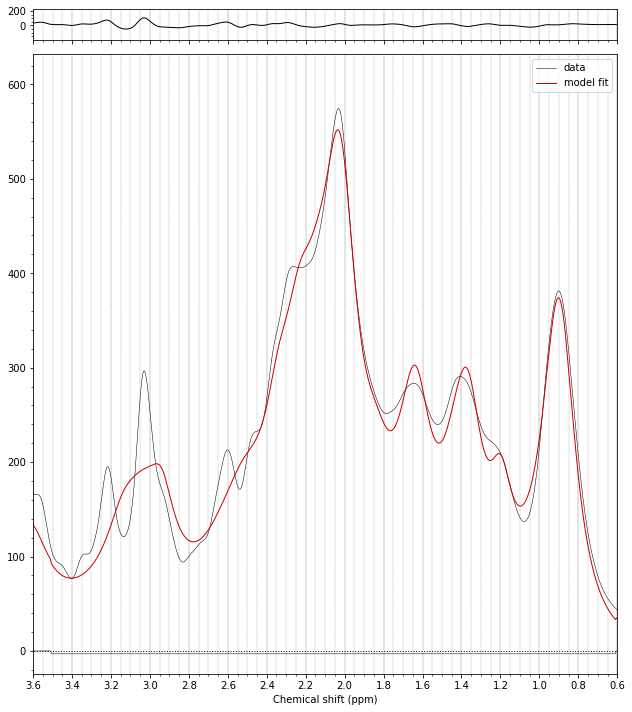

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



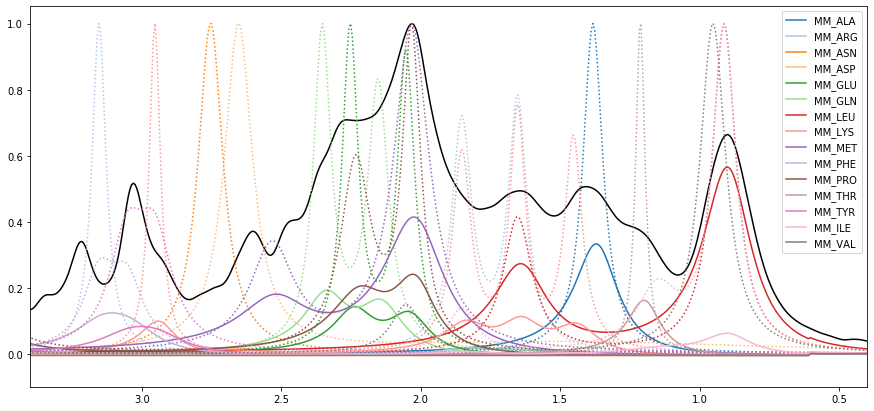

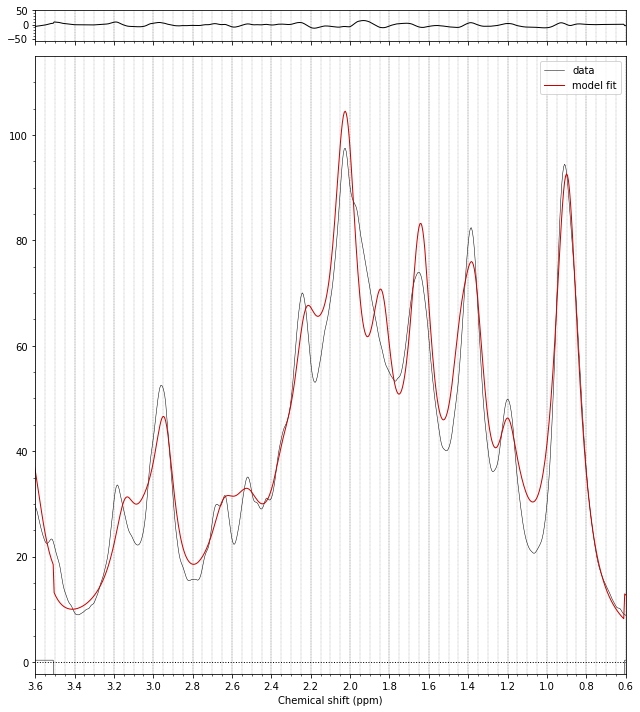

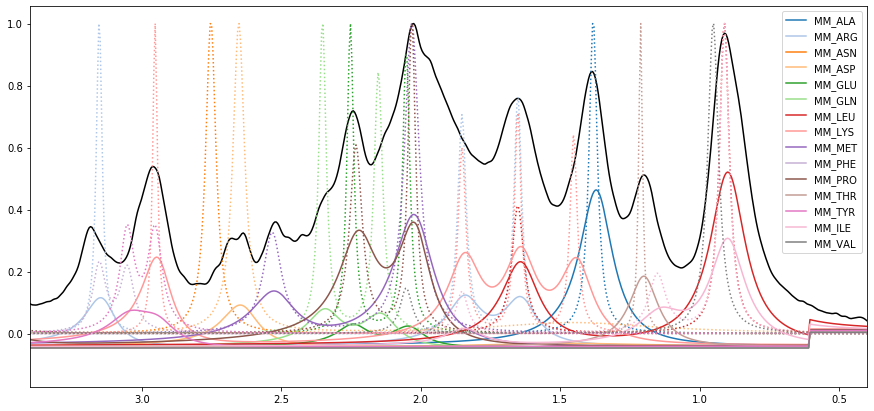

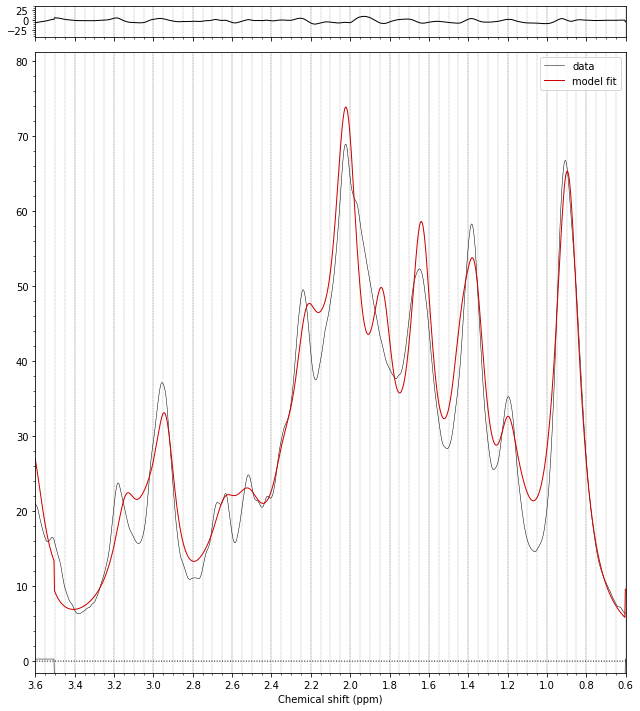

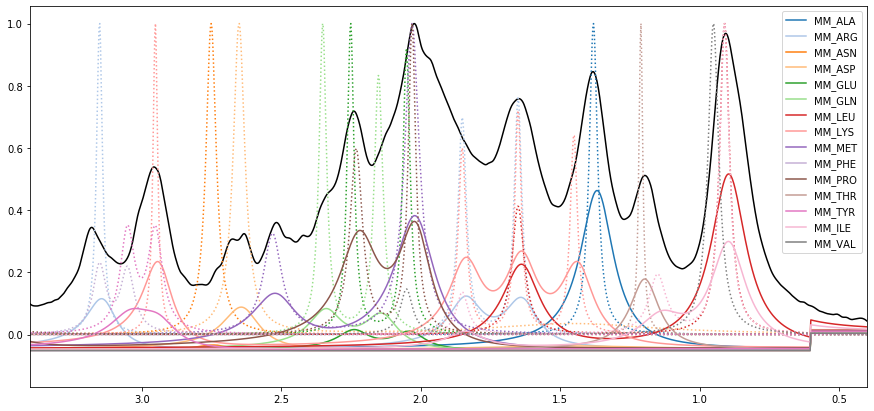

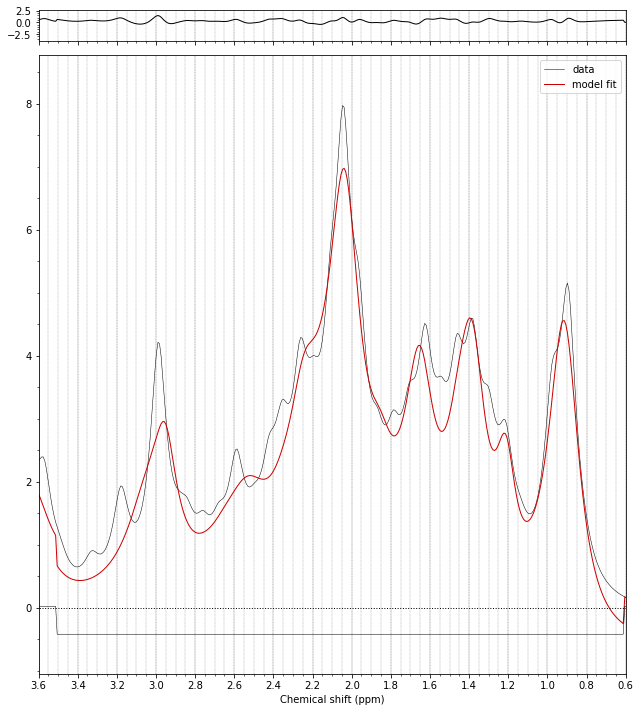

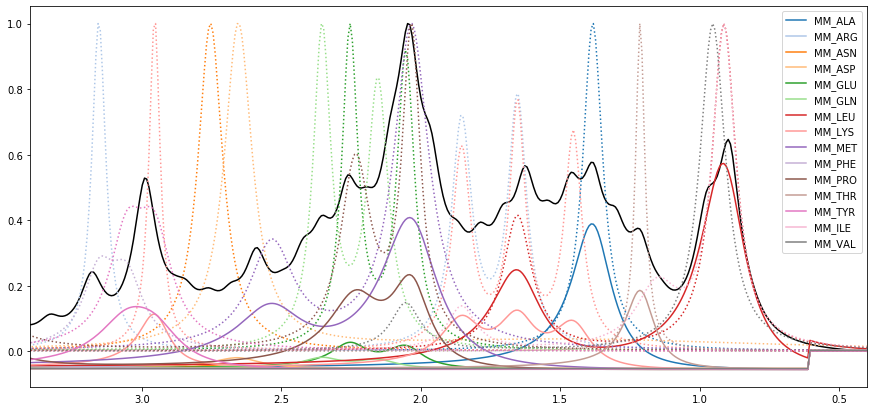

In [255]:
bplot = True
for iDx,(FID,cf,bw,points) in enumerate(zip(mmData,mmCf,mmBW,mmpoints)):
#     if iDx != 3:
#         continue
    basisFIDs,fidNames = mmbasis.getMMBasis(bw,points,cf/1E6,lw=60,addShift = -4.65)
    basisFIDs *= 1E-1
    mrs = MRS(FID=FID,basis=basisFIDs.T,names=fidNames,cf=cf,bw=bw)
    
    fitRange = (0.6,3.5)
    metab_groups = [0]*mrs.numBasis
    Fitargs = {'ppmlim':fitRange,
               'method':'Newton','baseline_order':0,
               'metab_groups':metab_groups}
    
    res = fitting.fit_FSLModel(mrs,**Fitargs)
    if bplot:
        _ = plotting.plot_fit(mrs,pred=res.pred,baseline=res.baseline,proj='real',ppmlim = fitRange)
    fig,ax1 = plt.subplots(1,1,figsize= (15,7))
    
    cmap = matplotlib.cm.get_cmap('tab20')

    toplot = np.real(plotting.FID2Spec(mrs.FID))
    ax1.plot(mrs.ppmAxis+4.65,toplot/np.max(toplot),'k')
    for iDx,m in enumerate(res.metabs):
            rgba = cmap(iDx)
            ax1.plot(mrs.ppmAxis+4.65,np.real(plotting.FID2Spec(plotting.pred(mrs,res,m)))/np.max(toplot),label=m,color=rgba)
            toPlot2 = np.real(plotting.FID2Spec(mrs.basis[:,iDx]))
            ax1.plot(mrs.ppmAxis+4.65,toPlot2/np.max(toPlot2),':',color=rgba)
    plt.xlim([0.4,3.4])
    plt.gca().invert_xaxis()
    plt.legend()
